In [1]:
!module load cuda/11.1

%matplotlib inline
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import gin
from PIL import Image

import collections
import functools
import os
import time
from typing import Any, Dict, Optional, Sequence

from absl import app
from absl import flags
from absl import logging
from flax import jax_utils
from flax import optim
from flax.metrics import tensorboard
from flax.training import checkpoints
import gin
import jax
from jax import numpy as jnp
from jax import random
from jax.config import config
import numpy as np
import tensorflow as tf
import tensorflow_hub as tf_hub
import pdb
import glob
import imageio

from hypernerf import configs
from hypernerf import datasets
from hypernerf import evaluation
from hypernerf import gpath
from hypernerf import image_utils
from hypernerf import model_utils
from hypernerf import models
from hypernerf import types
from hypernerf import utils
from hypernerf import visualization as viz

log_path = pathlib.Path('log/cdw/bungalows/decompose_no_far_v4')
rendering_path = log_path / 'renders-eval/00100000/train/train'
data_path = pathlib.Path('data/cdw/bungalows')
gt_path = data_path / 'groundtruth'
config_path = log_path / 'source.gin'

gin.parse_config_files_and_bindings(
  config_files=[str(config_path)],
  bindings=f"data_dir='{str(data_path)}'",
  skip_unknown=True)

# Load configurations.
exp_config = configs.ExperimentConfig()
train_config = configs.TrainConfig()
eval_config = configs.EvalConfig()


2022-03-14 09:46:55.964553: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/software/spack/spack-0.11.2/opt/spack/linux-rhel7-x86_64/gcc-5.4.0/openmpi-1.10.7-jdc7f4fjdq5roxhadufd6h66xkwuytss/lib:/usr/local/software/spack/spack-0.11.2/opt/spack/linux-rhel7-x86_64/gcc-4.8.5/gcc-5.4.0-fis24ggupugiobii56fesif2y3qulpdr/lib64:/usr/local/software/spack/spack-0.11.2/opt/spack/linux-rhel7-x86_64/gcc-4.8.5/gcc-5.4.0-fis24ggupugiobii56fesif2y3qulpdr/lib:/usr/local/Cluster-Apps/cuda/8.0/lib64:/usr/local/Cluster-Apps/cuda/8.0/lib:/usr/local/software/global/lib:/usr/local/Cluster-Apps/vgl/2.5.1/64/lib:/usr/local/software/slurm/current/lib
2022-03-14 09:46:56.100302: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so

In [2]:
if train_config.use_decompose_nerf:
    dummy_model = models.DecomposeNerfModel({}, 0, 0)
else:
    dummy_model = models.NerfModel({}, 0, 0)

datasource = exp_config.datasource_cls(
  image_scale=exp_config.image_scale,
  random_seed=exp_config.random_seed,
  # Enable metadata based on model needs.
  use_warp_id=dummy_model.use_warp,
  use_appearance_id=(
      dummy_model.nerf_embed_key == 'appearance'
      or dummy_model.hyper_embed_key == 'appearance'),
  use_camera_id=dummy_model.nerf_embed_key == 'camera',
  use_time=dummy_model.warp_embed_key == 'time',
  mask_interest_region=exp_config.mask_interest_region)

# read gif masks
mask_gif = imageio.get_reader(str(rendering_path / 'mask.gif'))
mask_preds = []
for frame in mask_gif:
    mask_preds.append(frame)
    
mask_preds = np.array(mask_preds) / 255

train_eval_ids = utils.strided_subset(
  datasource.train_ids, eval_config.num_train_eval) # returns eval_config.num_train_eval+1 evenly spaced samples 
train_eval_iter = datasource.create_iterator(train_eval_ids, batch_size=0)

# convert all batchs into a list for easy access
train_eval_batches = [ batch for (item_id, batch) in zip(train_eval_ids, train_eval_iter)] 

train_eval_ids

2022-03-14 09:47:05.126871: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


['in000001',
 'in000009',
 'in000018',
 'in000026',
 'in000035',
 'in000043',
 'in000052',
 'in000060',
 'in000069',
 'in000077',
 'in000086',
 'in000094',
 'in000103',
 'in000111',
 'in000120',
 'in000129',
 'in000137',
 'in000146',
 'in000154',
 'in000163',
 'in000171',
 'in000180',
 'in000188',
 'in000197',
 'in000205',
 'in000214',
 'in000222',
 'in000231',
 'in000240',
 'in000248',
 'in000257',
 'in000265',
 'in000274',
 'in000282',
 'in000291',
 'in000299',
 'in000308',
 'in000316',
 'in000325',
 'in000333',
 'in000342',
 'in000351',
 'in000359',
 'in000368',
 'in000376',
 'in000385',
 'in000393',
 'in000402',
 'in000410',
 'in000419',
 'in000427',
 'in000436',
 'in000444',
 'in000453',
 'in000462',
 'in000470',
 'in000479',
 'in000487',
 'in000496',
 'in000504',
 'in000513',
 'in000521',
 'in000530',
 'in000538',
 'in000547',
 'in000555',
 'in000564',
 'in000573',
 'in000581',
 'in000590',
 'in000598',
 'in000607',
 'in000615',
 'in000624',
 'in000632',
 'in000641',
 'in000649',

In [3]:
def compute_jaccard_index(mask_pred, mask_gt):
    # deal with region of interest
    mask_pred = mask_pred.reshape(-1)
    mask_gt = mask_gt.reshape(-1)
    mask_pred = mask_pred[mask_gt != -1]
    mask_gt = mask_gt[mask_gt != -1]
    
    tp = np.sum(mask_pred * mask_gt)
    fp = np.sum(mask_pred * (1-mask_gt))
    fn = np.sum((1-mask_pred) * mask_gt)
    return tp / (tp + fn + fp)

def compute_f1(mask_pred, mask_gt):
    # Compute F measure 

    # deal with region of interest
    mask_pred = mask_pred.reshape(-1)
    mask_gt = mask_gt.reshape(-1)
    mask_pred = mask_pred[mask_gt != -1]
    mask_gt = mask_gt[mask_gt != -1]

    tp = np.sum(mask_pred * mask_gt)
    fp = np.sum(mask_pred * (1-mask_gt))
    fn = np.sum((1-mask_pred) * mask_gt)
    return tp / (tp + 0.5 * (fn + fp))

in000325


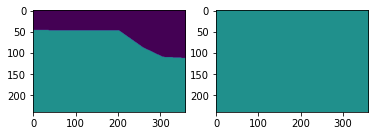

In [4]:
# %matplotlib inline

# ID = 38
# print(train_eval_ids[ID])
# batch = train_eval_batches[ID]
# mask_pred = mask_preds[ID]
# # mask_gt = np.where(batch['mask'] == -1, 0.5, batch['mask'])[...,0]
# mask_gt = batch['mask'][..., 0]

# fig, ax = plt.subplots(nrows=1, ncols=2)
# ax[0].imshow(mask_gt, vmin=-1, vmax=1)
# ax[1].imshow(mask_pred, vmin=-1, vmax=1)
# plt.show()
    


In [5]:
jacs = []
f1s = []
for i in range(len(train_eval_batches)):
    batch = train_eval_batches[i]
    mask_pred = mask_preds[i]
    mask_gt = batch['mask'][..., 0]
    jacs.append(compute_jaccard_index(mask_pred, mask_gt))
    f1s.append(compute_f1(mask_pred, mask_gt))
    
jacs = np.array(jacs)
f1s = np.array(f1s)

/tmp/ipykernel_13560/2279679354.py:11: RuntimeWarning: invalid value encountered in double_scalars
  return tp / (tp + fn + fp)
/tmp/ipykernel_13560/2279679354.py:25: RuntimeWarning: invalid value encountered in double_scalars
  return tp / (tp + 0.5 * (fn + fp))


In [6]:
print(f'Jac: {jacs[np.logical_not(np.isnan(jacs))].mean()}')

print(f'F1: {f1s[np.logical_not(np.isnan(f1s))].mean()}')

Jac: 0.741385768175718
F1: 0.8150859985014657


In [6]:
print(f'Jac: {jacs[np.logical_not(np.isnan(jacs))].mean()}')

print(f'F1: {f1s[np.logical_not(np.isnan(f1s))].mean()}')

Jac: 0.7747651247031835
F1: 0.8322865324085997


<IPython.core.display.Javascript object>


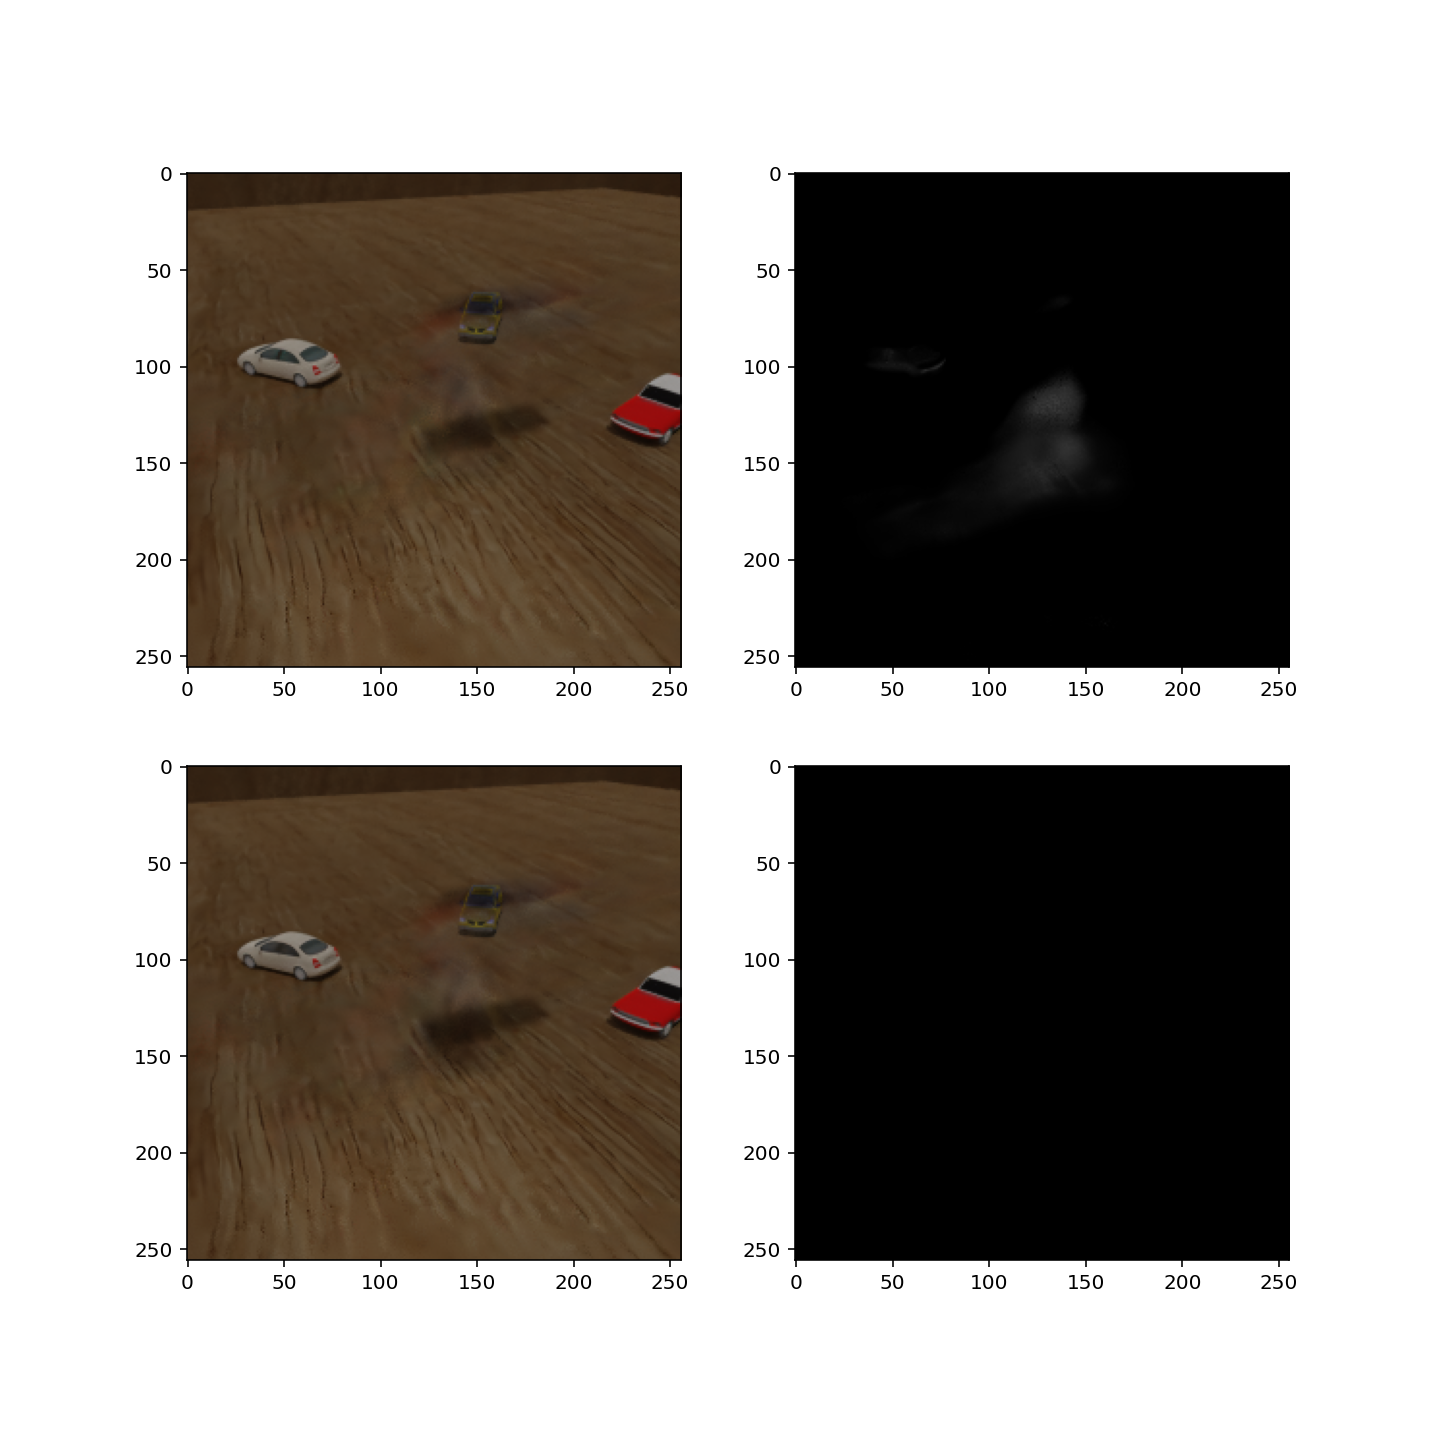

In [4]:
%matplotlib notebook
plt.rcParams['figure.figsize'] = [10,10]
fig, ax = plt.subplots(nrows=2, ncols=2)

ax[0,0].imshow(OUT['rgb'])
ax[0,1].imshow(OUT['extra_rgb_blendw'])
ax[1,0].imshow(OUT['extra_rgb_static'])
ax[1,1].imshow(OUT['extra_rgb_mask'])
plt.show()

In [5]:
# Note that pixel is obtained by rgb[y,x]
x, y = [135,115]
OUT['extra_rgb_blendw'][y,x]

array([0.17513451, 0.17513451, 0.17513451], dtype=float32)

In [6]:
OUT['blendw'][y,x]

array([0.38948235, 0.36381012, 0.35759178, 0.35725173, 0.3510666 ,
       0.3377575 , 0.31989902, 0.3013122 , 0.2882324 , 0.26326758,
       0.26157257, 0.23274778, 0.23017986, 0.2156955 , 0.20784855,
       0.19046025, 0.1804287 , 0.1746442 , 0.16906692, 0.16040783,
       0.15656176, 0.15556598, 0.15288097, 0.15572964, 0.15575913,
       0.13251463, 0.11965098, 0.02233415, 0.00160336, 0.00112128,
       0.00026988, 0.00003923, 0.00001643, 0.00000001, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [7]:
OUT['weights_d'][y,x]

array([0.0834657 , 0.00254142, 0.00011337, 0.00192108, 0.00406363,
       0.00486661, 0.00545404, 0.00450962, 0.00857891, 0.00058938,
       0.01093368, 0.00085254, 0.00519602, 0.00244464, 0.00657304,
       0.00309191, 0.00244296, 0.00339498, 0.00313889, 0.0016707 ,
       0.00036595, 0.00125756, 0.0123142 , 0.00137548, 0.00371944,
       0.00054522, 0.0020638 , 0.00015037, 0.00000105, 0.00000285,
       0.0000008 , 0.00000009, 0.00000019, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [14]:
OUT['weights_s'][y,x]

array([0.058613  , 0.01000494, 0.0013644 , 0.00438191, 0.01056284,
       0.00240741, 0.00112177, 0.01270549, 0.00115121, 0.00574672,
       0.00403524, 0.0065115 , 0.01200948, 0.02333473, 0.0044837 ,
       0.00144748, 0.01496681, 0.00930929, 0.00044126, 0.00660282,
       0.00604641, 0.02226742, 0.00925711, 0.00955795, 0.01305944,
       0.00343347, 0.00766395, 0.02511996, 0.00698721, 0.01207555,
       0.01909907, 0.05545145, 0.02104448, 0.00191875, 0.00715907,
       0.00071446, 0.0263818 , 0.01323691, 0.01920979, 0.02242503,
       0.00184718, 0.0008211 , 0.00080375, 0.00136468, 0.00133434,
       0.0285399 , 0.00004843, 0.0044719 , 0.00791124, 0.00935565,
       0.00191653, 0.01825105, 0.01346873, 0.00241892, 0.00256661,
       0.00327603, 0.00058665, 0.00086659, 0.00047451, 0.00096323,
       0.00005721, 0.00216617, 0.00000937, 0.00111568, 0.00084195,
       0.00037039, 0.00005468, 0.00001071, 0.0000451 , 0.00009769,
       0.00002605, 0.00008203, 0.00028038, 0.00009269, 0.00001

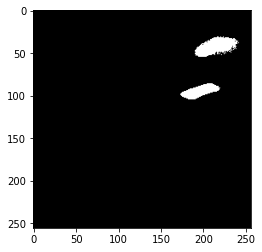

In [31]:
%matplotlib inline
plt.imshow(np.where(OUT['extra_rgb_blendw'] > 0.25, 1., 0.) )

In [8]:
OUT['mask']

KeyError: 'mask'